# Deep RL

1. inputs need to reflect position in arena and odor (NOT CONJUNCTIONS)
2. outputs need to reflect action values
3. actions are selected via softmax on output neuron activity. 
4. RPE requires knowing value of new state
   -- so this will require a forward pass using "new state" inputs.

In [1]:
# Import packages
import numpy as np
from tqdm import tqdm

# # Replace `%matplotlib ipympl` by `%matplotlib inline` in case you get javascript issues
# %matplotlib ipympl
import matplotlib.pyplot as plt

In [2]:
# Load custom functions
from utils import Params, Sigmoid
from deep_learning import Network

In [3]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Main options

In [4]:
nTrain = 1000000
nTest = 100
problem = 2

In [5]:
nTot = nTrain + nTest
# create two normal input channels
X = np.random.multivariate_normal([0, 0], 10 * np.eye(2), size=nTot)
# X = pd.read_csv("X.csv", header=None).to_numpy()
# Y is positive if X(1) & X(2) are positive, OR if X(1) and X(2) are negative.
X.shape

(1000100, 2)

In [6]:
Y = np.sign(X[:, 0] * X[:, 1]) / 2.0 + 0.5

## Choose the task parameters

In [7]:
# Choose the parameters for the task
p = Params(learning_rate=0.001, nLayers=5, nHiddenUnits=20)
p

Params(learning_rate=0.001, nLayers=5, nHiddenUnits=20)

## Step 2: Build network

In [8]:
nn = Network(
    nInputUnits=X.shape[1],
    nLayers=p.nLayers,
    nOutputUnits=1,
    nHiddenUnits=p.nHiddenUnits,
    initVar=1,
)

## Step 3: Train network

In [9]:
sigmoid = Sigmoid()


allError = np.nan * np.ones(nTot)
catPredict = np.nan * np.ones(nTot)

for i in tqdm(range(nTrain)):

    # Generate model prediction (forward pass of activity through units):
    activity = [np.array([]) for _ in range(p.nLayers)]
    for j in range(p.nLayers):
        # Determine layer input:
        if j == 0:
            input = X[i, :]  # THIS WILL BE YOUR POSITION/ODOR!!!!!
        else:
            if activity[j].shape == ():  # Convert to a vector in case it is scalar
                activity[j] = activity[j, np.newaxis]
            input = activity[j - 1] @ nn.wtMatrix[j - 1]

        # Apply non-linearity
        if nn.nonLin[j]:
            activity[j] = sigmoid(input)
        else:
            activity[j] = input

        # Take an action! softmax over actions or similar

        # incorporate your model of the task, to determine where agent actually goes.

        # Now you need to do another forward pass, to see how good the new
        # state is so that you can compute the RPE below.

        # your cost function will differ from the one below, should look something like this:
        # C =  R - X(S)*W+ DISCOUNT*max(X(S')*W)

    # Backpropagate errors to compute gradients for all layers:
    delta = [np.array([]) for _ in range(p.nLayers)]
    for j in reversed(range(p.nLayers)):
        # Determine layer input:
        if j == p.nLayers - 1:
            # IF there is nonlinearity, should multiply by derivative of
            # activation with respect to input (activity.*(1-activity)) here.
            delta[j] = (Y[i] - activity[j]) * (
                sigmoid.gradient(activity[j])
            ).T  # THIS SHOULD BE REPLACED WITH YOUR COST FUNCTION!

            # doing this in RL framework means that you'll need one RPE for
            # each output neuron -- so RPE computed above should be
            # associated with the action agent took... all other RPEs
            # should be zero.

        else:
            # OK, here is the magic -- neurons in layer j share the
            # gradient (ie. prediction errors) from the next layer
            # according to their responsibility... that is to say, if I
            # project to a unit in next layer with a strong weight,
            # then i inherit the gradient (PE) of that unit.
            if delta[j + 1].shape == ():  # Convert to a vector in case it is scalar
                delta[j + 1] = delta[j + 1, np.newaxis]
            delta[j] = (
                nn.wtMatrix[j] @ delta[j + 1] * (activity[j] * (1.0 - activity[j])).T
            )

    # Update weight matrices according to gradients and activities:
    for j in range(len(nn.wtMatrix) - 1):
        nn.wtMatrix[j] = (
            nn.wtMatrix[j]
            + p.learning_rate * np.expand_dims(activity[j], axis=1) * delta[j + 1].T
        )

    # store error:
    allError[i] = delta[-1]
    catPredict[i] = activity[-1] > 0.5

100%|█████████████████████████████████████████████████████| 1000000/1000000 [01:43<00:00, 9627.28it/s]


In [10]:
activity

[array([-2.49434973,  2.64674577]),
 array([5.94709825e-03, 1.75932084e-01, 1.37951348e-02, 2.37811446e-03,
        9.98783174e-01, 4.22982139e-02, 1.11225773e-02, 8.75047581e-03,
        9.85279182e-01, 9.85317890e-01, 9.96122697e-01, 3.90908451e-04,
        1.12717688e-02, 2.81103358e-02, 9.74697168e-01, 9.88625725e-01,
        2.15348572e-02, 6.33342866e-04, 9.42596088e-01, 1.71125216e-02]),
 array([5.90334221e-02, 1.23155521e-01, 2.04484272e-04, 9.76186018e-01,
        1.51270888e-01, 9.21634481e-01, 9.55514398e-01, 2.99826348e-03,
        7.96713234e-01, 9.61367141e-01, 9.51627901e-01, 9.62284079e-01,
        9.39726078e-01, 7.52235320e-02, 5.33750927e-01, 9.92833604e-01,
        1.85279948e-01, 8.53151011e-01, 3.42010616e-02, 1.00280778e-01]),
 array([0.11306207, 0.00125101, 0.96170884, 0.00622573, 0.91250225,
        0.18874343, 0.02590809, 0.0059873 , 0.67746148, 0.77460885,
        0.09379118, 0.89705248, 0.24186817, 0.12169349, 0.80143564,
        0.26146386, 0.78140215, 0.65

In [11]:
delta

[array([0.00131264, 0.00051256]),
 array([ 9.47551052e-06,  1.58418621e-04, -6.47872164e-06,  3.91056145e-06,
        -5.93169061e-07,  1.02159975e-05,  8.91645255e-06, -1.10014558e-05,
         2.61183901e-05,  6.97580223e-06,  1.37226464e-05,  1.30499008e-08,
         9.36254801e-06,  7.09778396e-05,  1.03360529e-05,  6.34321139e-06,
        -2.62536310e-05, -5.83211316e-07,  1.10984956e-04,  6.33125512e-06]),
 array([-3.47884716e-04, -8.91150256e-04,  1.34380704e-06,  2.26906584e-05,
        -6.08279351e-04, -7.15119184e-05,  1.02240460e-04,  1.32601495e-05,
         1.59533863e-04,  3.40975253e-04,  8.78142053e-05,  1.70430733e-04,
        -1.74170774e-04,  3.34095450e-05,  2.75206623e-04,  1.25000608e-05,
        -4.91779160e-04,  6.27187942e-05, -1.01342551e-04, -7.90222094e-04]),
 array([-2.30651101e-04,  6.07198297e-06,  7.51642119e-05,  3.05063485e-05,
         9.16404092e-04, -6.07011542e-04, -3.94589127e-04, -3.38796593e-06,
         1.43324499e-03,  9.39136200e-04, -2.64324

In [12]:
allError

array([-0.10430231,  0.10506354,  0.13766761, ...,         nan,
               nan,         nan])

In [13]:
catPredict

array([ 0.,  1.,  0., ..., nan, nan, nan])

In [14]:
Bins = np.round(np.linspace(0, len(allError), num=100)).astype(int)

meanError = np.zeros_like(Bins) * np.nan
for i in range(len(Bins) - 1):
    meanError[i] = np.nanmean(abs(allError[Bins[i] : Bins[i + 1]]))
meanError

array([0.11893808, 0.11471634, 0.11127525, 0.10833737, 0.10562374,
       0.10299526, 0.10046747, 0.09789971, 0.09521947, 0.09276584,
       0.09042597, 0.08792664, 0.08564318, 0.08311717, 0.08062542,
       0.07840148, 0.07605802, 0.07404804, 0.0719261 , 0.07005348,
       0.06820087, 0.06600171, 0.06442733, 0.06286766, 0.06101701,
       0.05958701, 0.05818915, 0.05661884, 0.05547537, 0.05438028,
       0.05329556, 0.05241336, 0.05098709, 0.0497184 , 0.04850778,
       0.047871  , 0.04706279, 0.04573437, 0.04552577, 0.0442934 ,
       0.04369298, 0.04309464, 0.04215058, 0.04146016, 0.04087063,
       0.04023445, 0.03956305, 0.0395683 , 0.03893947, 0.03844621,
       0.03771687, 0.03703016, 0.03665319, 0.03630506, 0.03553412,
       0.03501328, 0.03477809, 0.03441805, 0.03389006, 0.03366038,
       0.03313165, 0.0325872 , 0.03283644, 0.03269492, 0.03231402,
       0.03146054, 0.03127918, 0.0313731 , 0.03098955, 0.03003361,
       0.03038822, 0.02992437, 0.03007376, 0.02947901, 0.02932

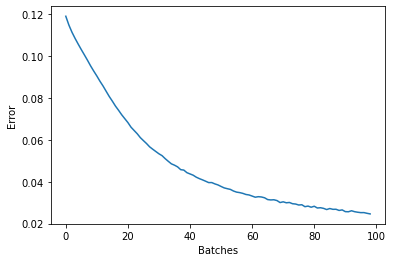

In [15]:
fig2 = plt.figure(2)
fig2.clear(True)
plt.plot(meanError)
plt.ylabel("Error")
plt.xlabel("Batches")
plt.show()

## Step 4: Test Network

In [17]:
for i in range((nTrain + 1), nTot):
    # Generate model prediction (forward pass of activity through units):
    activity = [np.array([]) for _ in range(p.nLayers)]
    for j in range(p.nLayers):
        # Determine layer input:
        if j == 0:
            input = X[i, :]  # initial layer is activated according to input
        else:
            input = activity[j - 1] @ nn.wtMatrix[j - 1]

        # Apply non-linearity
        if nn.nonLin[j]:
            activity[j] = sigmoid(input)
        else:
            activity[j] = input

    # store error
    allError[i] = delta[-1]
    catPredict[i] = activity[-1] > 0.5

isTest = np.zeros(nTot, dtype=bool)
isTest[nTrain + 1 :] = True

In [18]:
activity

[array([-3.81385633, -2.68831208]),
 array([9.95828101e-01, 9.87468481e-01, 9.19897536e-01, 9.97749037e-01,
        1.25831526e-03, 4.92489784e-03, 9.13974901e-04, 1.43472519e-03,
        2.38210902e-02, 1.14234231e-02, 9.99785060e-01, 5.85509777e-06,
        9.82188405e-01, 5.19939420e-03, 9.96926227e-01, 9.77749804e-03,
        2.67951618e-03, 9.99107274e-01, 9.69537883e-01, 2.23721037e-03]),
 array([9.88916486e-01, 9.28840005e-04, 6.32533180e-02, 1.25359898e-01,
        9.34940709e-01, 6.67054546e-01, 9.80231991e-01, 2.04584356e-02,
        7.40367960e-01, 7.61563178e-02, 9.87143871e-01, 5.78114042e-02,
        2.68961512e-03, 9.21452234e-02, 9.37216988e-01, 9.89233380e-01,
        8.44103026e-01, 9.09098299e-02, 5.61202520e-04, 6.80563850e-04]),
 array([9.16138102e-01, 3.41489511e-02, 9.68120323e-01, 6.73041750e-02,
        3.41927880e-02, 3.53950783e-02, 9.78283876e-01, 4.92652308e-02,
        7.70348152e-02, 8.21302227e-02, 4.69743569e-01, 3.09872969e-02,
        2.74353086e-01, 

In [19]:
allError

array([-0.10430231,  0.10506354,  0.13766761, ..., -0.00826633,
       -0.00826633, -0.00826633])

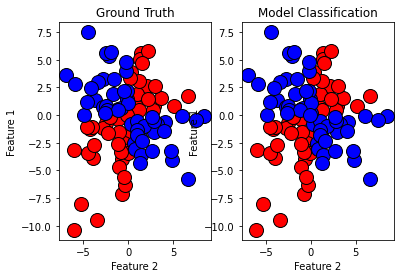

In [20]:
fig3 = plt.figure(3)
fig3.clear(True)
plt.subplot(1, 2, 1)
plt.title("Ground Truth")
# plt.plot([-2, 2], [0, 0], "--k")
# plt.plot([0, 0], [-2, 2], "--k")
plt.plot(
    X[(Y == 1) & isTest, 0],
    X[(Y == 1) & isTest, 1],
    "o",
    markerfacecolor="r",
    linewidth=1,
    markeredgecolor="k",
    markersize=14,
)
plt.plot(
    X[(Y == 0) & isTest, 0],
    X[(Y == 0) & isTest, 1],
    "o",
    markerfacecolor="b",
    linewidth=1,
    markeredgecolor="k",
    markersize=14,
)
plt.ylabel("Feature 1")
plt.xlabel("Feature 2")


plt.subplot(1, 2, 2)
plt.title("Model Classification")
# plt.plot([-2, 2], [0, 0], "--k")
# plt.plot([0, 0], [-2, 2], "--k")
plt.plot(
    X[(catPredict == 1) & isTest, 0],
    X[(catPredict == 1) & isTest, 1],
    "o",
    markerfacecolor="r",
    linewidth=1,
    markeredgecolor="k",
    markersize=14,
)
plt.plot(
    X[(catPredict == 0) & isTest, 0],
    X[(catPredict == 0) & isTest, 1],
    "o",
    markerfacecolor="b",
    linewidth=1,
    markeredgecolor="k",
    markersize=14,
)
plt.ylabel("Feature 1")
plt.xlabel("Feature 2")

plt.show()